<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2006-08-25 to 2025-10-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    5000 non-null   float64
dtypes: float64(1)
memory usage: 78.1 KB


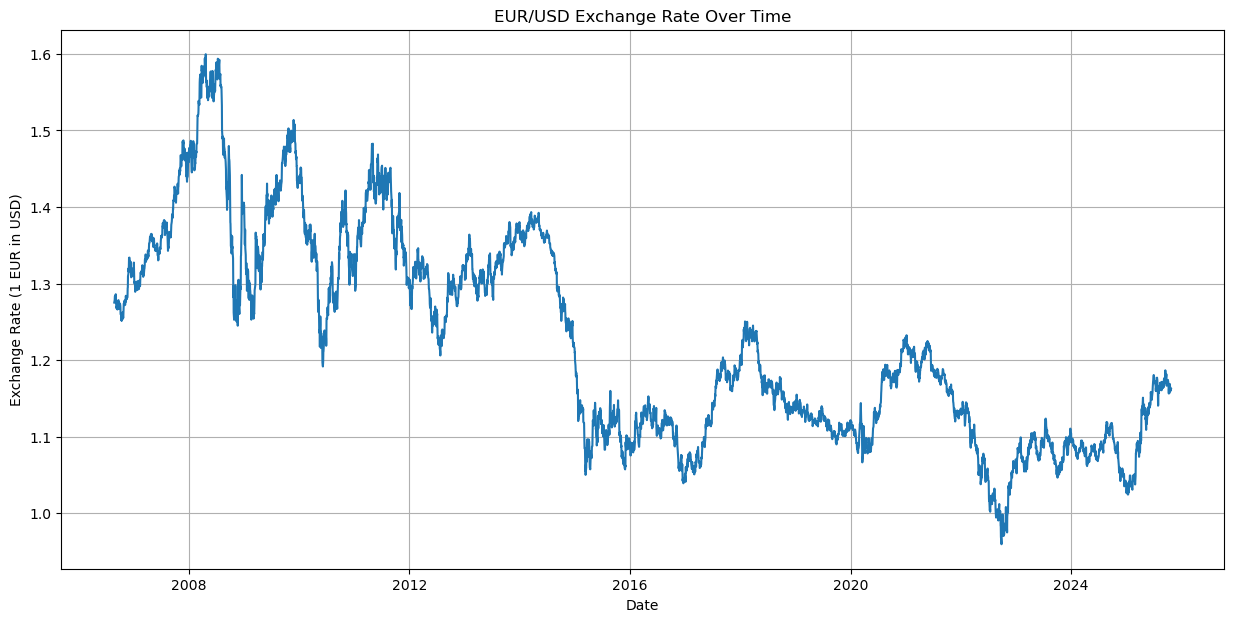

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the Data

DATA_PATH = os.path.join('..', 'data', 'processed', 'eur_usd_daily.csv')

df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
df.info()

plt.figure(figsize=(15, 7))
# the Rate column
plt.plot(df['Rate'])

plt.title('EUR/USD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (1 EUR in USD)')
plt.grid(True)

# plot
plt.show()

In [3]:
# handling missing values
missing_values = df['Rate'].isnull().sum()
print(f"Total missing values: {missing_values}")

if missing_values > 0:
    print("Missing values!")
    df['Rate'] = df['Rate'].ffill()
    print("Missing values filled.")
else:
    print("Data is complete. No missing values to fill.")

Total missing values: 0
Data is complete. No missing values to fill.


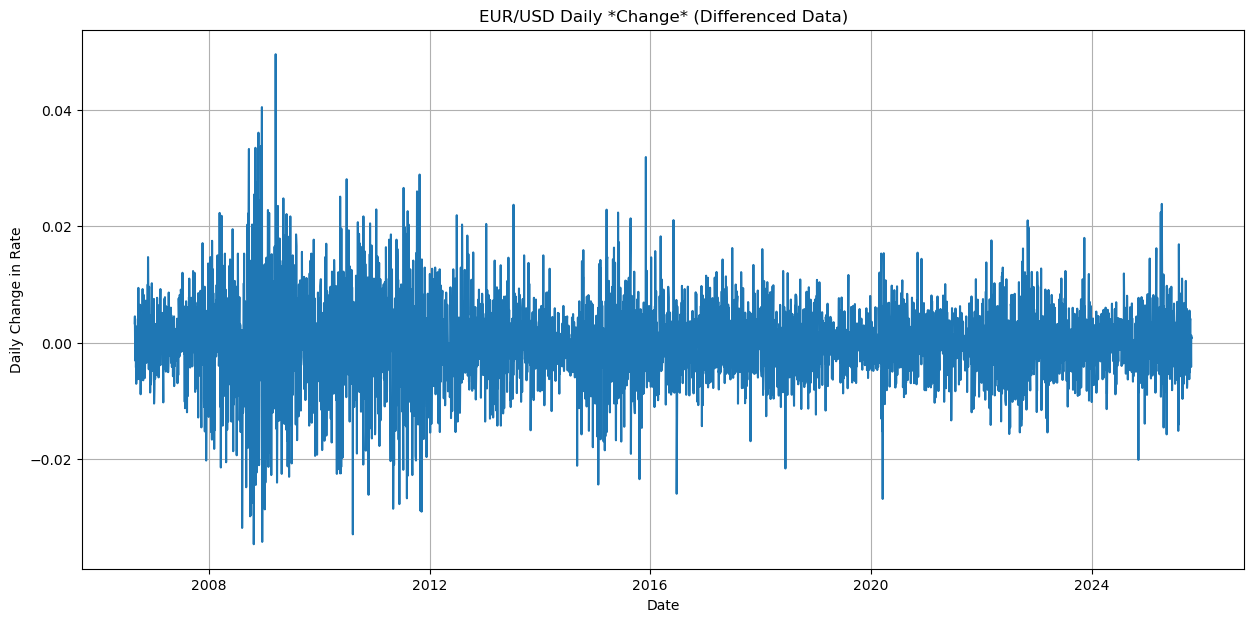

Original data (first 5 rows):
              Rate  Rate_diff
Date                         
2006-08-25  1.2751        NaN
2006-08-28  1.2784     0.0033
2006-08-29  1.2829     0.0045
2006-08-30  1.2837     0.0008
2006-08-31  1.2806    -0.0031

Stationary data (first 5 rows):
              Rate  Rate_diff
Date                         
2006-08-28  1.2784     0.0033
2006-08-29  1.2829     0.0045
2006-08-30  1.2837     0.0008
2006-08-31  1.2806    -0.0031
2006-09-01  1.2835     0.0029


In [4]:
# Calculate the difference from one day to the ne
df['Rate_diff'] = df['Rate'].diff(1)

df_stationary = df.dropna()

# Plot the New, Stationary Data
plt.figure(figsize=(15, 7))
plt.plot(df_stationary['Rate_diff'])
plt.title('EUR/USD Daily *Change* (Differenced Data)')
plt.xlabel('Date')
plt.ylabel('Daily Change in Rate')
plt.grid(True)
plt.show()

print("Original data (first 5 rows):")
print(df.head())
print("\nStationary data (first 5 rows):")
print(df_stationary.head())

In [6]:
from statsmodels.tsa.stattools import adfuller

# ADF Test on original "Rate" data
adf_test_original = adfuller(df['Rate'])
print(f'Original Data p-value: {adf_test_original[1]}')

# ADF Test on differenced "Rate_diff" data

adf_test_stationary = adfuller(df_stationary['Rate_diff'])
print(f'Differenced Data p-value: {adf_test_stationary[1]}')

print('\nADF Test Results:')
if adf_test_original[1] > 0.05:
    print('Original data is NOT stationary (p-value > 0.05)')
else:
    print('Original data IS stationary (p-value <= 0.05)')

if adf_test_stationary[1] > 0.05:
    print('Differenced data is NOT stationary (p-value > 0.05)')
else:
    print('Differenced data IS stationary (p-value <= 0.05)')

Original Data p-value: 0.3766051104389503
Differenced Data p-value: 0.0

ADF Test Results:
Original data is NOT stationary (p-value > 0.05)
Differenced data IS stationary (p-value <= 0.05)


Total data points: 4999
Training data points: 4634
Test data points: 365


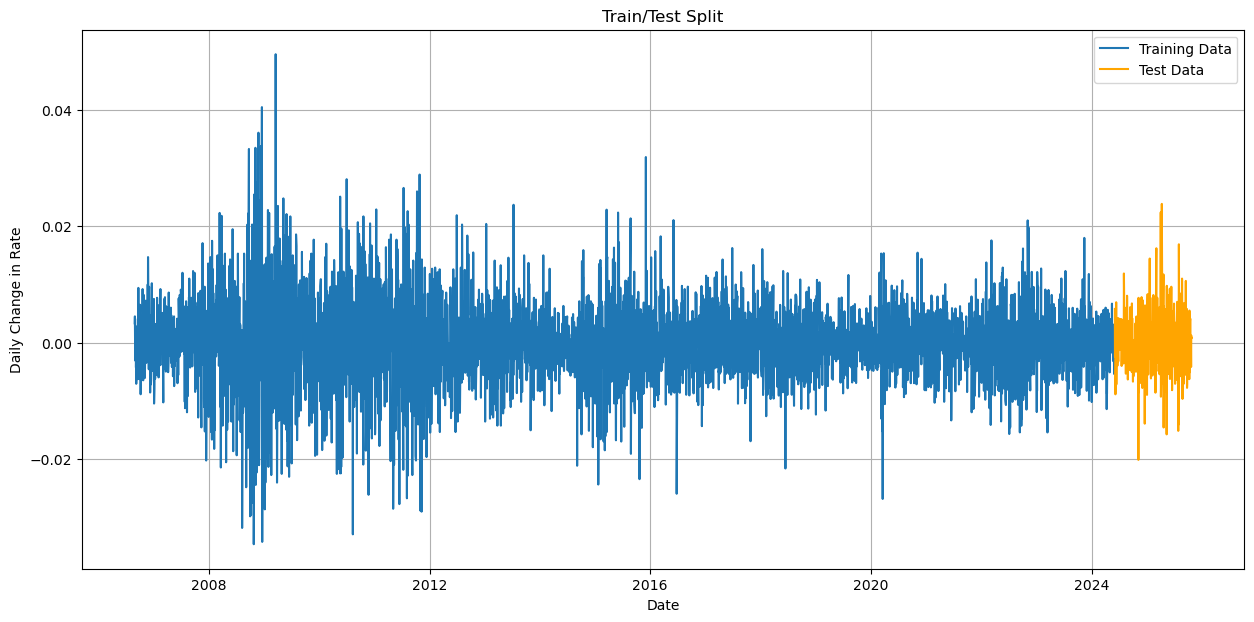

In [7]:
# keeping last 365 days for testing.
split_point = len(df_stationary) - 365

# Create train and test sets
train_data = df_stationary.iloc[:split_point]
test_data = df_stationary.iloc[split_point:]

print(f"Total data points: {len(df_stationary)}")
print(f"Training data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

plt.figure(figsize=(15, 7))
plt.plot(train_data['Rate_diff'], label='Training Data')
plt.plot(test_data['Rate_diff'], label='Test Data', color='orange')
plt.title('Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Daily Change in Rate')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

split_point_orig = len(df) - 365
train_orig = df.iloc[:split_point_orig]
test_orig = df.iloc[split_point_orig:]

print("Starting to train the ARIMA model...")
print("This may take a minute...")

# Define the model
model = ARIMA(train_orig['Rate'], order=(1, 1, 1))

# 2. Train (fit) the model
model_fit = model.fit()

print(model_fit.summary())

print("\nModel training complete!")

Starting to train the ARIMA model...
This may take a minute...


C:\Users\manoj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\manoj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\manoj\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\manoj\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

                               SARIMAX Results                                
Dep. Variable:                   Rate   No. Observations:                 4635
Model:                 ARIMA(1, 1, 1)   Log Likelihood               16350.047
Date:                Sun, 09 Nov 2025   AIC                         -32694.093
Time:                        07:55:45   BIC                         -32674.770
Sample:                             0   HQIC                        -32687.295
                               - 4635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       1.579e-08      0.005   2.92e-06      1.000      -0.011       0.011
ma.L1       1.572e-08      0.005   2.91e-06      1.000      -0.011       0.011
sigma2      5.045e-05   6.63e-07     76.067      0.0

Data index fixed. Re-training model...


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Model re-trained successfully.
Generating forecasts...
Root Mean Squared Error (RMSE): 0.05081


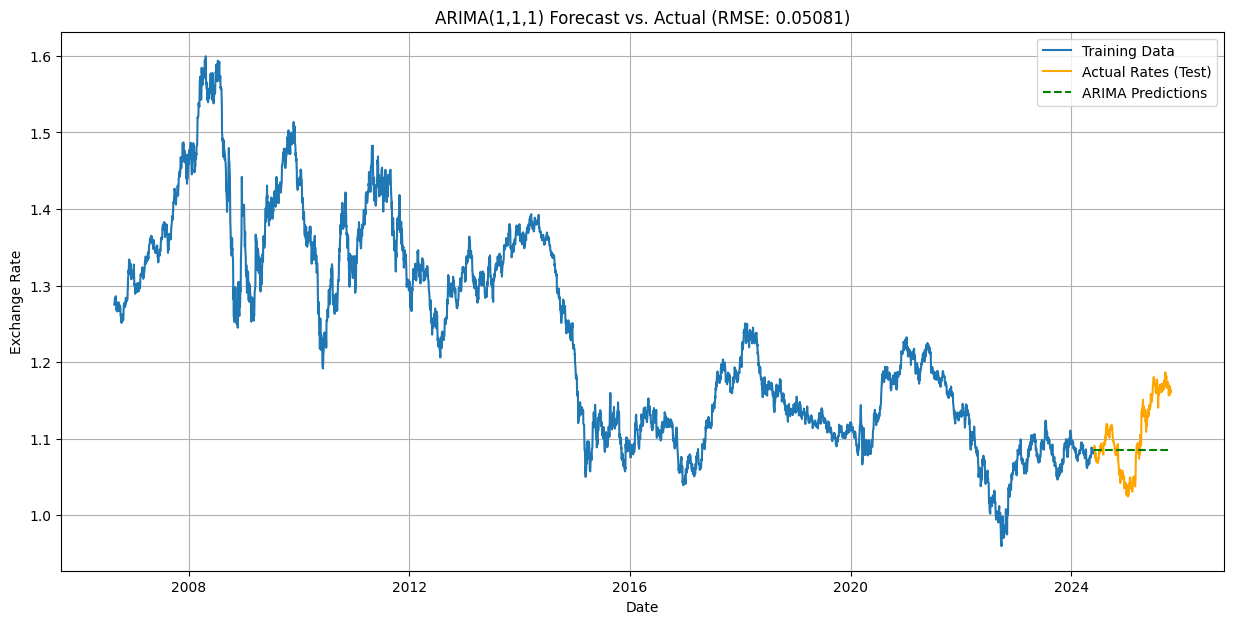

In [7]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Reload the data and FIX THE INDEX ---
# We must tell pandas our data is 'Daily'
# 'B' stands for 'Business Day', which is more accurate for market data
DATA_PATH = os.path.join('..', 'data', 'processed', 'eur_usd_daily.csv')
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)

# This is the fix: Set the index frequency to 'Business Day'
df = df.asfreq('B') 
# .asfreq() might create new NaNs on holidays, so we fill them
df['Rate'] = df['Rate'].ffill() 

# --- 2. Split the data again (now with a proper index) ---
split_point = len(df) - 365
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

print("Data index fixed. Re-training model...")

# --- 3. Re-train the model ---
# We train on the 'train_data' which has a clean date index
model = ARIMA(train_data['Rate'], order=(1, 1, 1))
model_fit = model.fit()

print("Model re-trained successfully.")

# --- 4. Forecast (The *cleaner* way) ---
print("Generating forecasts...")

# This is the modern, cleaner way to get forecasts.
# It automatically uses the correct dates.
predictions = model_fit.forecast(steps=len(test_data))
predictions.name = 'ARIMA Predictions' # Rename the series for the legend

# --- 5. Evaluate and Plot (Now it will be perfect) ---
rmse = np.sqrt(mean_squared_error(test_data['Rate'], predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")

plt.figure(figsize=(15, 7))
plt.plot(train_data['Rate'], label='Training Data')
plt.plot(test_data['Rate'], label='Actual Rates (Test)', color='orange')
plt.plot(predictions, label='ARIMA Predictions', color='green', linestyle='--')
plt.title(f'ARIMA(1,1,1) Forecast vs. Actual (RMSE: {rmse:.5f})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

Training final model on ALL data...


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Final model trained successfully.

--- Forecast for the next 30 business days ---
2025-10-27    1.1625
2025-10-28    1.1625
2025-10-29    1.1625
2025-10-30    1.1625
2025-10-31    1.1625
2025-11-03    1.1625
2025-11-04    1.1625
2025-11-05    1.1625
2025-11-06    1.1625
2025-11-07    1.1625
2025-11-10    1.1625
2025-11-11    1.1625
2025-11-12    1.1625
2025-11-13    1.1625
2025-11-14    1.1625
2025-11-17    1.1625
2025-11-18    1.1625
2025-11-19    1.1625
2025-11-20    1.1625
2025-11-21    1.1625
2025-11-24    1.1625
2025-11-25    1.1625
2025-11-26    1.1625
2025-11-27    1.1625
2025-11-28    1.1625
2025-12-01    1.1625
2025-12-02    1.1625
2025-12-03    1.1625
2025-12-04    1.1625
2025-12-05    1.1625
Freq: B, Name: predicted_mean, dtype: float64


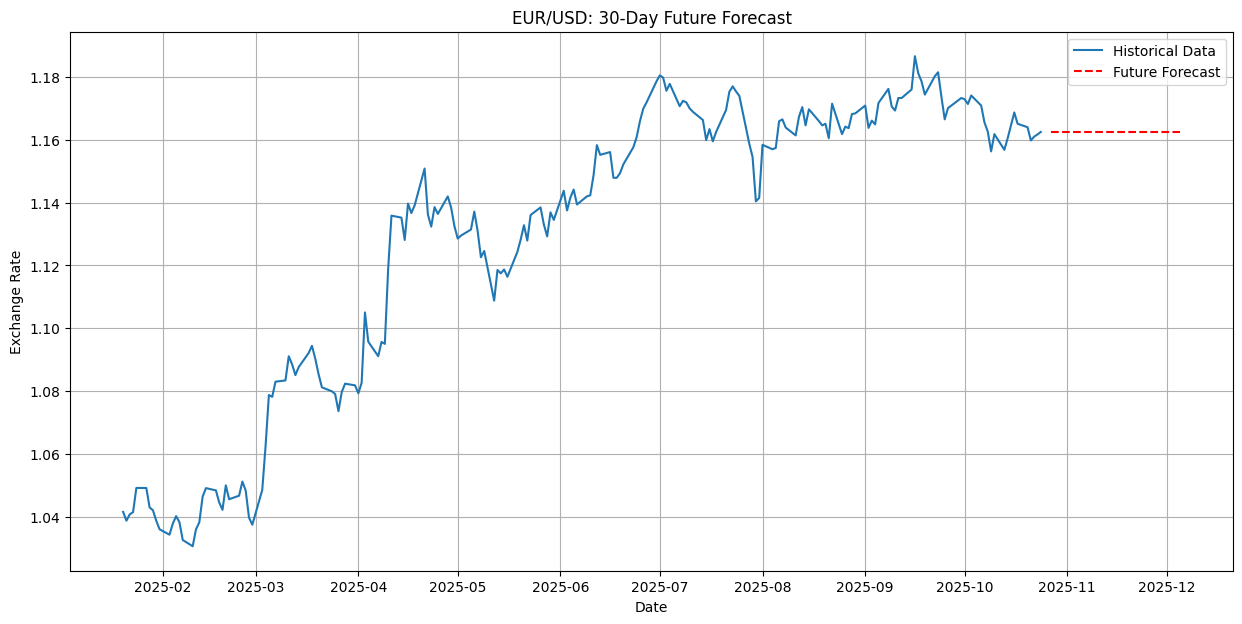

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- 1. Load ALL data and set frequency ---
DATA_PATH = os.path.join('..', 'data', 'processed', 'eur_usd_daily.csv')
df_full = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
df_full = df_full.asfreq('B') # 'B' for Business Day
df_full['Rate'] = df_full['Rate'].ffill()

print("Training final model on ALL data...")

# --- 2. Train the model on 100% of the data ---
# We use the same (1, 1, 1) order
final_model = ARIMA(df_full['Rate'], order=(1, 1, 1))
final_model_fit = final_model.fit()

print("Final model trained successfully.")

# --- 3. Forecast the next 30 days ---
# Let's predict the next 30 business days
forecast_steps = 30
forecast = final_model_fit.forecast(steps=forecast_steps)

print(f"\n--- Forecast for the next {forecast_steps} business days ---")
print(forecast)

# --- 4. Plot the final forecast ---
plt.figure(figsize=(15, 7))
# Plot the last 200 days of history
plt.plot(df_full['Rate'].tail(200), label='Historical Data')
# Plot the future forecast
plt.plot(forecast, label='Future Forecast', color='red', linestyle='--')
plt.title('EUR/USD: 30-Day Future Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import pmdarima as pm
from pmdarima import model_selection
import pandas as pd
import os

# --- 1. Load and prepare your data ---
DATA_PATH = os.path.join('..', 'data', 'processed', 'eur_usd_daily.csv')
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
df = df.asfreq('B') # Set frequency to Business Day
df['Rate'] = df['Rate'].ffill()

# Split the data
split_point = len(df) - 365
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

print("Data loaded. Starting auto_arima...")
print("This will take several minutes, please be patient...")

# --- 2. Run auto_arima ---
auto_model = pm.auto_arima(
    train_data['Rate'],
    start_p=1, start_q=1,
    test='adf',       # Use ADF test to find d
    max_p=3, max_q=3, # Maximum p and q to test
    m=1,              # No seasonality
    d=None,           # Let auto_arima find the best 'd'
    seasonal=False,   # No seasonality
    start_P=0, 
    D=0, 
    trace=True,       # Print out the results of each test
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True     # Speeds up the search
)

# --- 3. Print the results ---
print("\n--- auto_arima search complete ---")
print(auto_model.summary())

Data loaded. Starting auto_arima...
This will take several minutes, please be patient...
Performing stepwise search to minimize aic


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-32698.160, Time=1.06 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15156.598, Time=0.40 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.87 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.70 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=5.05 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-32696.227, Time=2.08 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2741.555, Time=3.90 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.49 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-32693.162, Time=2.90 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-32704.809, Time=3.13 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-11405.310, Time=3.95 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=3.00 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-32587.566, Time=13.48 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-32702.871, Time=3.01 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5305.640, Time=1.39 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-16282.901, Time=6.33 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=3.25 sec


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-32699.010, Time=4.35 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 60.400 seconds

--- auto_arima search complete ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4636
Model:               SARIMAX(1, 0, 1)   Log Likelihood               16356.405
Date:                Sat, 25 Oct 2025   AIC                         -32704.809
Time:                        02:25:25   BIC                         -32679.043
Sample:                    08-25-2006   HQIC                        -32695.744
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0

Training the new auto_arima model: ARIMA(1,0,1)...
Model trained.
Generating forecasts...

--- Model Comparison ---
Old Baseline RMSE (ARIMA(1,1,1)): 0.05081
New AutoARIMA RMSE (ARIMA(1,0,1)): 0.03885

Result: SUCCESS! The new model is better.


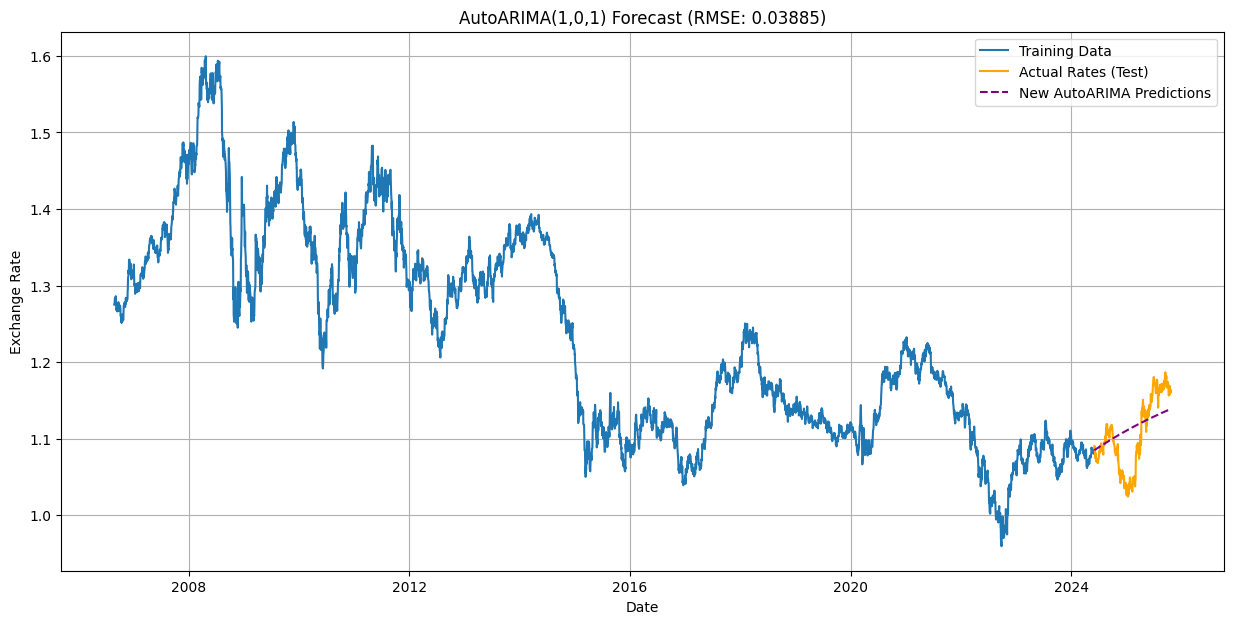

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt  # <-- THIS IS THE FIX

# We'll use the 'train_data' and 'test_data' we already have in memory

print("Training the new auto_arima model: ARIMA(1,0,1)...")

# --- 1. Train the new model ---
# We use order=(1,0,1) as auto_arima suggested
new_model = ARIMA(train_data['Rate'], order=(1, 0, 1))
new_model_fit = new_model.fit()

print("Model trained.")

# --- 2. Forecast on the test set ---
print("Generating forecasts...")
predictions = new_model_fit.forecast(steps=len(test_data))
predictions.name = 'AutoARIMA Predictions'

# --- 3. Evaluate and Compare ---
new_rmse = np.sqrt(mean_squared_error(test_data['Rate'], predictions))

print("\n--- Model Comparison ---")
print(f"Old Baseline RMSE (ARIMA(1,1,1)): 0.05081")
print(f"New AutoARIMA RMSE (ARIMA(1,0,1)): {new_rmse:.5f}")

if new_rmse < 0.05081:
    print("\nResult: SUCCESS! The new model is better.")
else:
    print("\nResult: The new model did not beat the baseline.")

# --- 4. Plot the new forecast ---
plt.figure(figsize=(15, 7))
plt.plot(train_data['Rate'], label='Training Data')
plt.plot(test_data['Rate'], label='Actual Rates (Test)', color='orange')
plt.plot(predictions, label='New AutoARIMA Predictions', color='purple', linestyle='--')
plt.title(f'AutoARIMA(1,0,1) Forecast (RMSE: {new_rmse:.5f})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# --- 1. Load and Prep Data ---
DATA_PATH = os.path.join('..', 'data', 'processed', 'eur_usd_daily.csv')
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
df = df.asfreq('B')
df['Rate'] = df['Rate'].ffill()

# We only need the 'Rate' values
data = df['Rate'].values.reshape(-1, 1) # Reshape to a 2D array for the scaler

# --- 2. Scale the Data (0 to 1) ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# --- 3. Split into Train/Test *before* creating sequences ---
# We'll use the same 365-day test split
split_point = len(scaled_data) - 365
train_data = scaled_data[0:split_point, :]
test_data = scaled_data[split_point - 60:, :] # We need 60 days of history for the *first* test point

# --- 4. Create the Sequences ---
# This function will create our "sliding windows"
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

TIME_STEP = 60 # We'll look at 60 days of history

X_train, y_train = create_sequences(train_data, TIME_STEP)
X_test, y_test = create_sequences(test_data, TIME_STEP)

# --- 5. Reshape for LSTM ---
# An LSTM needs 3D data: [samples, time_steps, features]
# We have 1 feature (the 'Rate')
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"--- Data Prepared for LSTM ---")
print(f"X_train shape (Samples, Timesteps, Features): {X_train.shape}")
print(f"y_train shape (Labels): {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Prepared for LSTM ---
X_train shape (Samples, Timesteps, Features): (4576, 60, 1)
y_train shape (Labels): (4576,)
X_test shape: (365, 60, 1)
y_test shape: (365,)


Building LSTM model...


c:\Users\manoj\anaconda3\envs\fx_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Training model... This will take a few minutes.
Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0090 - val_loss: 5.0348e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0024 - val_loss: 3.3933e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0023 - val_loss: 5.5126e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0020 - val_loss: 5.5355e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0019 - val_loss: 5.5850e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0018 - val_loss: 2.9471e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0016 - val_loss: 2.5291e-04
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0015 - val_loss: 2.3238e-04
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0014 - val_loss: 2.3226e-04
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0015 - val_loss: 2.4892e-04
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━

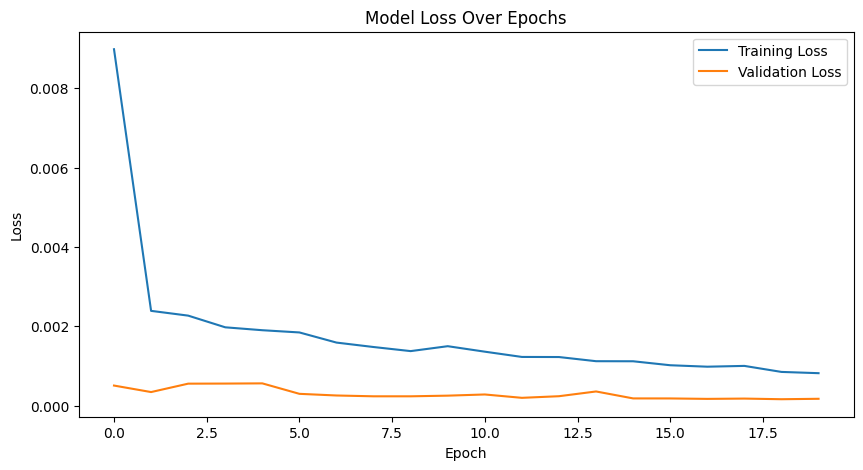

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- 6. Build the LSTM Model ---
print("Building LSTM model...")
model = Sequential()
model.add(LSTM(
    units=50, 
    return_sequences=True,  # True because we might add another LSTM layer
    input_shape=(X_train.shape[1], 1) # (60, 1)
))
model.add(Dropout(0.2)) # Prevent overfitting

# A second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1)) # A single output neuron

# --- 7. Compile the Model ---
# 'adam' is a smart optimizer, 'mean_squared_error' is our loss function
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary() # Print a summary of the model

# --- 8. Train the Model ---
print("\nTraining model... This will take a few minutes.")
# We'll train for 20 "epochs" (passes through the data)
# batch_size=32 means it processes 32 samples at a time
history = model.fit(
    X_train, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1 # Show the progress bar
)
print("Model training complete!")

# --- 9. Plot the training loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Making predictions on test data...
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
Un-scaling predictions...

Training RMSE: 0.01097
Test RMSE: 0.00834

--- Model Comparison ---
Best ARIMA RMSE (ARIMA(1,0,1)): 0.03885
New LSTM RMSE: 0.00834

Result: SUCCESS! The LSTM model is better.

Plotting the results...


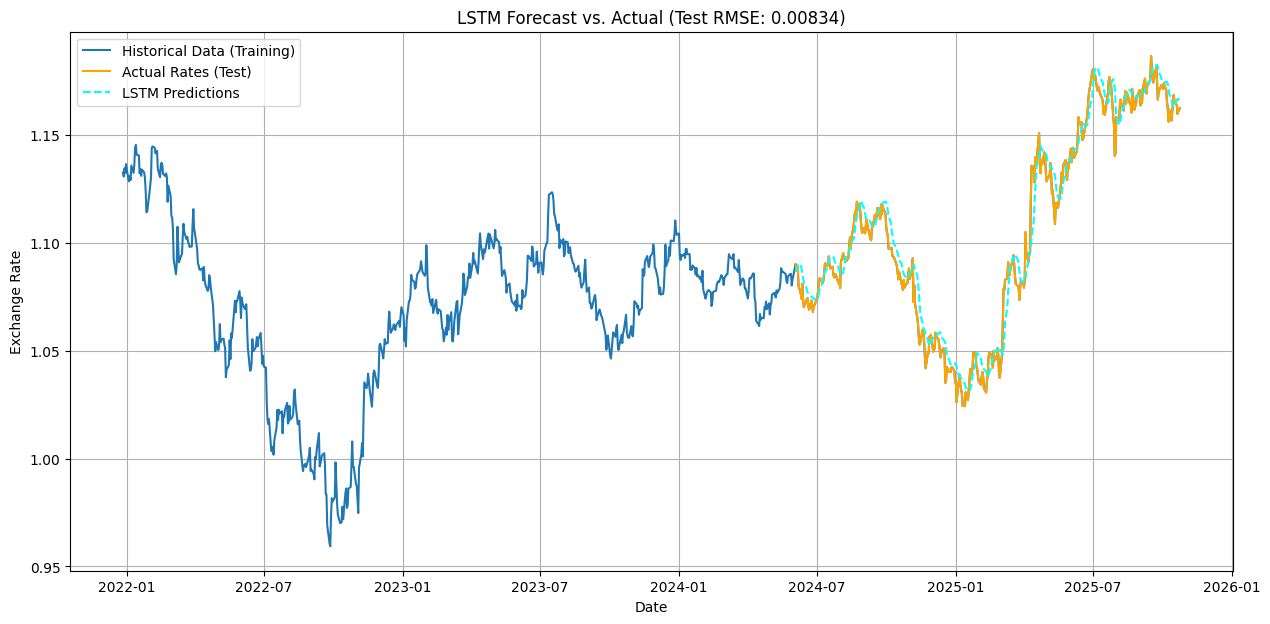

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# --- 10. Make Predictions ---
print("Making predictions on test data...")
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# --- 11. Un-scale the Predictions ---
# We must use the 'scaler' object we created earlier
# to transform the data back to its original price scale.
print("Un-scaling predictions...")
train_predict = scaler.inverse_transform(train_predict)
y_train_unscaled = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- 12. Calculate RMSE ---
train_rmse = np.sqrt(mean_squared_error(y_train_unscaled, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_unscaled, test_predict))

print(f"\nTraining RMSE: {train_rmse:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

# --- 13. Compare to ARIMA ---
best_arima_rmse = 0.03885
print(f"\n--- Model Comparison ---")
print(f"Best ARIMA RMSE (ARIMA(1,0,1)): {best_arima_rmse}")
print(f"New LSTM RMSE: {test_rmse:.5f}")

if test_rmse < best_arima_rmse:
    print("\nResult: SUCCESS! The LSTM model is better.")
else:
    print("\nResult: The LSTM model did not beat the ARIMA model.")

# --- 14. Plot the results ---
# We need to create a clean DataFrame for plotting
# The test predictions start 60 days *after* the start of the test data
plot_data = df[split_point:].copy()

# Add the unscaled 'y_test' values as the 'Actual' column
plot_data['Actual'] = y_test_unscaled

# The predictions (test_predict) have the same length as y_test (365)
# So we can just add them as a new column
plot_data['LSTM_Prediction'] = test_predict

print("\nPlotting the results...")
plt.figure(figsize=(15, 7))
plt.plot(df['Rate'].tail(1000), label='Historical Data (Training)') # Plot last 1000 days
plt.plot(plot_data['Actual'], label='Actual Rates (Test)', color='orange')
plt.plot(plot_data['LSTM_Prediction'], label='LSTM Predictions', color='cyan', linestyle='--')
plt.title(f'LSTM Forecast vs. Actual (Test RMSE: {test_rmse:.5f})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

Performing rolling forecast for the next 30 days...

--- LSTM Forecast for the next 30 business days ---
2025-10-27    1.165622
2025-10-28    1.166000
2025-10-29    1.166704
2025-10-30    1.167580
2025-10-31    1.168547
2025-11-03    1.169558
2025-11-04    1.170591
2025-11-05    1.171632
2025-11-06    1.172673
2025-11-07    1.173709
2025-11-10    1.174740
2025-11-11    1.175762
2025-11-12    1.176777
2025-11-13    1.177783
2025-11-14    1.178782
2025-11-17    1.179774
2025-11-18    1.180760
2025-11-19    1.181740
2025-11-20    1.182715
2025-11-21    1.183686
2025-11-24    1.184654
2025-11-25    1.185619
2025-11-26    1.186582
2025-11-27    1.187543
2025-11-28    1.188503
2025-12-01    1.189461
2025-12-02    1.190418
2025-12-03    1.191375
2025-12-04    1.192331
2025-12-05    1.193286
Freq: B, dtype: float32


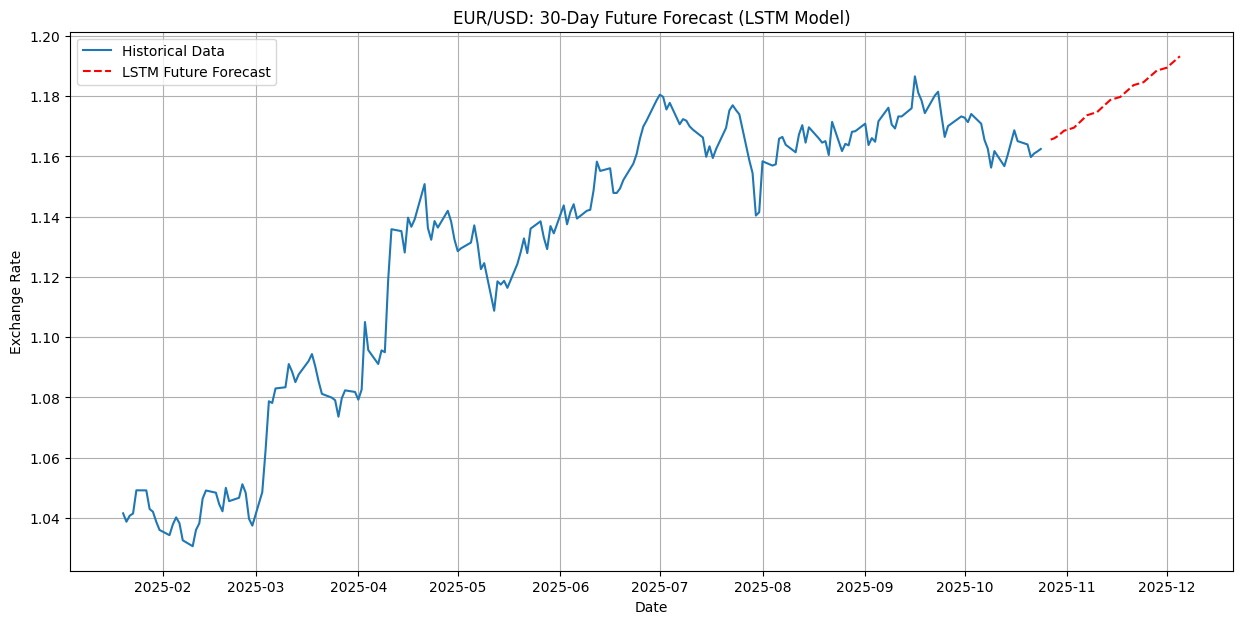

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Get the last 60 days of data ---
# We'll use the 'scaler' and 'model' we just trained

# Get the last 60 days from the original dataset
last_60_days_data = df['Rate'].values[-TIME_STEP:]

# Scale this data
last_60_days_scaled = scaler.transform(last_60_days_data.reshape(-1, 1))

# Reshape it for the LSTM
X_input = last_60_days_scaled.reshape(1, TIME_STEP, 1)

# --- 2. Perform the Rolling Forecast ---
print("Performing rolling forecast for the next 30 days...")
temp_predictions = []
n_steps = 30 # How many days to predict

for i in range(n_steps):
    # Get the prediction (scaled)
    # verbose=0 just silences the print-out for each prediction
    pred_scaled = model.predict(X_input, verbose=0)
    
    # Store the prediction
    temp_predictions.append(pred_scaled[0, 0])
    
    # --- This is the "rolling" part ---
    # 1. Create a new input array
    # 2. Remove the *first* day (the oldest one)
    # 3. Add the *new prediction* to the *end*
    new_input = np.append(X_input[0, 1:, 0], pred_scaled[0, 0])
    
    # 4. Reshape it back to what the model expects
    X_input = new_input.reshape(1, TIME_STEP, 1)


# --- 3. Un-scale the final forecast ---
final_forecast_scaled = np.array(temp_predictions).reshape(-1, 1)
final_forecast = scaler.inverse_transform(final_forecast_scaled)

# --- 4. Create dates for the forecast ---
last_date = df.index[-1]
# Create 30 new 'Business Day' dates starting from the day *after* our last data point
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=n_steps, freq='B')

# Create a clean pandas Series for plotting
forecast_series = pd.Series(final_forecast.flatten(), index=forecast_dates)

print("\n--- LSTM Forecast for the next 30 business days ---")
print(forecast_series)

# --- 5. Plot the final forecast ---
plt.figure(figsize=(15, 7))
plt.plot(df['Rate'].tail(200), label='Historical Data')
plt.plot(forecast_series, label='LSTM Future Forecast', color='red', linestyle='--')
plt.title('EUR/USD: 30-Day Future Forecast (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()